In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import ADASYN
df = pd.read_csv('./Data/data+descvf.csv')
tl = TomekLinks()
x=df.iloc[:, :-3]
y = df.account_type.values.tolist()
x, y = tl.fit_resample(x, y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42,stratify=y)



# RandomizedSearchCV

In [9]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Specify the range of values for some important hyperparameters

In [14]:
n_estimators_list = list(range(10,220,50))
criterion_list = ['gini', 'entropy']
max_depth_list = list(range(5,41,10))
max_depth_list.append(None)
min_samples_split_list = [x/1000 for x in list(range(5, 41, 10))]
min_samples_leaf_list = [x/1000 for x in list(range(5, 41, 10))]
max_features_list = ['sqrt', 'log2']
params_grid = {
    'n_estimators': n_estimators_list,
    'criterion': criterion_list,
    'max_depth': max_depth_list,
    'min_samples_split': min_samples_split_list,
    'min_samples_leaf': min_samples_leaf_list,
    'max_features': max_features_list
}

num_combinations = 1
for k in params_grid.keys(): num_combinations *= len(params_grid[k])

print('Number of combinations = ', num_combinations)
params_grid

Number of combinations =  1600


{'n_estimators': [10, 60, 110, 160, 210],
 'criterion': ['gini', 'entropy'],
 'max_depth': [5, 15, 25, 35, None],
 'min_samples_split': [0.005, 0.015, 0.025, 0.035],
 'min_samples_leaf': [0.005, 0.015, 0.025, 0.035],
 'max_features': ['sqrt', 'log2']}

In [20]:
def my_roc_auc_score(model,x_train,y_train): return metrics.roc_auc_score(y_train, model.predict(x_train))

model_rf = RandomizedSearchCV(estimator=RandomForestClassifier(),
                              param_distributions=params_grid,
                             
                              cv=3,
                            #   scoring=my_roc_auc_score,
                              return_train_score=True,
                              verbose=2)

model_rf.fit(x_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=0.015, min_samples_split=0.025, n_estimators=110; total time=   1.0s
[CV] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=0.015, min_samples_split=0.025, n_estimators=110; total time=   0.9s
[CV] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=0.015, min_samples_split=0.025, n_estimators=110; total time=   1.0s
[CV] END criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=0.035, min_samples_split=0.025, n_estimators=210; total time=   1.5s
[CV] END criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=0.035, min_samples_split=0.025, n_estimators=210; total time=   1.6s
[CV] END criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=0.035, min_samples_split=0.025, n_estimators=210; total time=   1.5s
[CV] END criterion=entropy, max_depth=None, max_features=log

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 15, 25, 35, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [0.005, 0.015,
                                                             0.025, 0.035],
                                        'min_samples_split': [0.005, 0.015,
                                                              0.025, 0.035],
                                        'n_estimators': [10, 60, 110, 160,
                                                         210]},
                   return_train_score=True,
                   scoring=<function my_roc_auc_score at 0x7f4bbdf24d30>,
                   verbose=2)

In [18]:
model_rf.best_params_

{'n_estimators': 110,
 'min_samples_split': 0.005,
 'min_samples_leaf': 0.005,
 'max_features': 'log2',
 'max_depth': 15,
 'criterion': 'entropy'}

In [27]:
df_cv_results = pd.DataFrame(model_rf.cv_results_)
df_cv_results = df_cv_results[['rank_test_score','mean_test_score','mean_train_score',
                           'param_n_estimators', 'param_min_samples_split','param_min_samples_leaf',
                           'param_max_features', 'param_max_depth','param_criterion']]

df_cv_results.sort_values('rank_test_score', inplace=True)
df_cv_results[:20]


,rank_test_score,mean_test_score,mean_train_score,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion
53,1,0.845814,0.851212,110,0.005,0.005,sqrt,35,gini
68,2,0.845319,0.851127,160,0.005,0.005,sqrt,15,entropy
84,3,0.841956,0.846489,210,0.015,0.005,log2,15,entropy
87,4,0.841898,0.848140,10,0.005,0.005,log2,None,entropy
95,5,0.841268,0.845466,210,0.015,0.005,log2,None,gini
59,6,0.841250,0.846532,10,0.005,0.005,log2,35,entropy
79,7,0.839963,0.844945,210,0.015,0.005,log2,15,gini
54,8,0.837440,0.842544,10,0.015,0.005,log2,15,gini
63,9,0.833966,0.837350,210,0.025,0.005,log2,None,entropy
74,10,0.833829,0.837065,160,0.025,0.005,sqrt,35,entropy


In [28]:

df_cv_results.to_csv('./Data/random_search.csv', index=False)

In [19]:
# x y
# {'n_estimators': 110,
#  'min_samples_split': 0.005,
#  'min_samples_leaf': 0.005,
#  'max_features': 'sqrt',
#  'max_depth': 35,
#  'criterion': 'gini'}

# x_train y_train
# {'n_estimators': 110,
#  'min_samples_split': 0.005,
#  'min_samples_leaf': 0.005,
#  'max_features': 'log2',
#  'max_depth': 15,
#  'criterion': 'entropy'}
model_rf_fin = RandomForestClassifier(class_weight='balanced',
                                      criterion='entropy',
                                      max_depth=15,
                                      max_features='log2',
                                      min_samples_leaf=0.005,
                                      min_samples_split=0.005,
             
                                      n_estimators=110)
model_rf_fin.fit(x_train,y_train)


y_pred_train = model_rf_fin.predict(x_train)
y_pred_test = model_rf_fin.predict(x_test)
print("\n Training Accuracy score:",metrics.accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",metrics.accuracy_score(y_test, y_pred_test))




 Training Accuracy score: 0.8511363636363637
Testing Accuracy score: 0.8513636363636363


Grid Search

param_grid1

In [29]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)


{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'max_features': ['log2', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [30]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
from sklearn.model_selection import GridSearchCV
rf_Grid = GridSearchCV(estimator = RandomForestClassifier(), 
                       param_grid = param_grid, cv = 3, verbose=2, n_jobs = 4)
rf_Grid.fit(x, y)


Fitting 3 folds for each of 320 candidates, totalling 960 fits
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.1s

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72,
                                          80]},
             verbose=2)

In [31]:

rf_Grid.best_params_
# x_train y_train

# {'bootstrap': False,
#  'max_depth': 4,
#  'max_features': 'log2',
#  'min_samples_leaf': 2,
#  'min_samples_split': 2,
#  'n_estimators': 17}

# x y

# {'bootstrap': True,
#  'max_depth': 4,
#  'max_features': 'sqrt',
#  'min_samples_leaf': 2,
#  'min_samples_split': 2,
#  'n_estimators': 17}

{'bootstrap': True,
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 17}


 Training Accuracy score: 0.8231160245548734
Testing Accuracy score: 0.8123541828685702
classification_report 
               precision    recall  f1-score   support

           0       0.81      0.81      0.81      4501
           1       0.81      0.81      0.81      4500

    accuracy                           0.81      9001
   macro avg       0.81      0.81      0.81      9001
weighted avg       0.81      0.81      0.81      9001



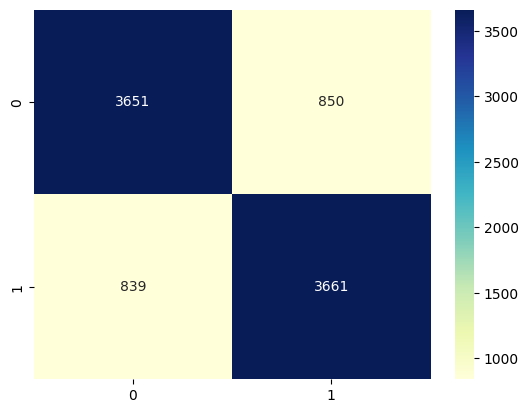

In [5]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import gender_guesser.detector as gender
import matplotlib.pyplot as plt 
from datetime import datetime
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
data1 = pd.read_csv('./Data/data+column_relation.csv')
df=data1.loc[:,[ 'statuses', 'date_joined',
       'most_recent_post', 'following', 'followers',  'favourites', 'lists',
          'tweets_this_week','retweet', 'retweeted_count',
        'userNameScore', 
       'avg_tweets_by_day_of_week', 
       'engagment_rate', 'description', 'screen_name', 'account_type']]
from sklearn.model_selection import KFold, cross_val_score
from imblearn.over_sampling import SMOTE


x=df.iloc[:, :-3]
y = df.account_type.values.tolist()

smote = SMOTE(random_state=10)
x, y =smote.fit_resample(x, y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42,stratify=y)
clf = RandomForestClassifier(bootstrap=False,
                                      
                                      max_depth=4,
                                      max_features='log2',
                                      min_samples_leaf=2,
                                      min_samples_split=2,
            
                                      n_estimators=17)
clf.fit(x_train,y_train)

y_pred_train = clf.predict(x_train)
y_pred_test = clf.predict(x_test)
print("\n Training Accuracy score:",metrics.accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",metrics.accuracy_score(y_test, y_pred_test))
print("classification_report \n "+classification_report(y_test, y_pred_test))
cm = metrics.confusion_matrix(y_test, y_pred_test)
# print('Confusion matrix\n', cm)

cm_matrixNB = pd.DataFrame(data=cm, )
sns.heatmap(cm_matrixNB, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [35]:
model_rf_fin = RandomForestClassifier( bootstrap= True,max_depth= 4,max_features= 'sqrt',min_samples_leaf= 2,min_samples_split= 2, n_estimators= 17)

model_rf_fin.fit(x_train,y_train)


y_pred_train = model_rf_fin.predict(x_train)
y_pred_test = model_rf_fin.predict(x_test)
print("\n Training Accuracy score:",metrics.accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",metrics.accuracy_score(y_test, y_pred_test))


 Training Accuracy score: 0.8123863636363636
Testing Accuracy score: 0.8131818181818182


param_grid2

In [38]:


n_estimators_list = list(range(10,220,50))
criterion_list = ['gini', 'entropy']
max_depth_list = list(range(5,41,10))
max_depth_list.append(None)
min_samples_split_list = [x/1000 for x in list(range(5, 41, 10))]
min_samples_leaf_list = [x/1000 for x in list(range(5, 41, 10))]
max_features_list = ['sqrt', 'log2']
param_grid = {
    'n_estimators': n_estimators_list,
    'criterion': criterion_list,
    'max_depth': max_depth_list,
    'min_samples_split': min_samples_split_list,
    'min_samples_leaf': min_samples_leaf_list,
    'max_features': max_features_list
}


In [39]:
rf_Grid = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv = 3, verbose=2, n_jobs = 4)
rf_Grid.fit(x, y)

Fitting 3 folds for each of 1600 candidates, totalling 4800 fits
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.005, min_samples_split=0.005, n_estimators=10; total time=   0.1s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.005, min_samples_split=0.005, n_estimators=10; total time=   0.1s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.005, min_samples_split=0.005, n_estimators=10; total time=   0.1s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.005, min_samples_split=0.005, n_estimators=60; total time=   0.6s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.005, min_samples_split=0.005, n_estimators=60; total time=   0.6s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.005, min_samples_split=0.005, n_estimators=60; total time=   0.6s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.005, mi

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 15, 25, 35, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [0.005, 0.015, 0.025, 0.035],
                         'min_samples_split': [0.005, 0.015, 0.025, 0.035],
                         'n_estimators': [10, 60, 110, 160, 210]},
             verbose=2)

In [40]:

rf_Grid.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 0.005,
 'min_samples_split': 0.005,
 'n_estimators': 160}

In [41]:
# {'criterion': 'entropy',
#  'max_depth': None,
#  'max_features': 'sqrt',
#  'min_samples_leaf': 0.005,
#  'min_samples_split': 0.005,
#  'n_estimators': 160}
model_rf_fin = RandomForestClassifier(criterion= 'entropy',max_depth= None,max_features= 'sqrt',min_samples_leaf= 0.005,min_samples_split= 0.005, n_estimators= 160)

model_rf_fin.fit(x_train,y_train)

y_pred_train = model_rf_fin.predict(x_train)
y_pred_test = model_rf_fin.predict(x_test)
print("\n Training Accuracy score:",metrics.accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",metrics.accuracy_score(y_test, y_pred_test))


 Training Accuracy score: 0.8507954545454546
Testing Accuracy score: 0.8518181818181818
